# Zillow Kaggle Project - NYC Data Science Academy
## Patrick Masi-Phelps, Katie Critelli, John Merrick, Ningxi Xu
### Data manipulation, machine learning with GBM, XGBoost, kNN

### Model stacking at the end

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, normalize, scale
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from datetime import datetime
import random
from sklearn.cross_validation import train_test_split
import math
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_curve,auc
from statsmodels.tools import categorical
from sklearn.neighbors import KNeighborsRegressor

color = sns.color_palette()
%matplotlib inline

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv', index_col=0)
properties = pd.read_csv('imputed_final.csv', index_col=0)
train_master = train
properties_master = properties

/Users/Patrick/anaconda/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [292]:
properties_og = pd.read_csv('properties_2016.csv')

/Users/Patrick/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.



In [84]:
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
drop_cols = [
    'fips',
    'propertycountylandusecode',
    'censustractandblock',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'regionidcity',
    'regionidneighborhood',
    'regionidzip',
    'assessmentyear', # same year
    'hashottuborspa',
    'year',
    'month',
    'threequarterbathnbr'
]

for col in properties_master.columns:
    if col in drop_cols:
        properties_master = properties_master.drop(col, axis=1)
        train_master = train_master.drop(col, axis=1)       

In [4]:
train_master = train_master.drop('month', axis=1)
train_master = train_master.drop('year', axis=1)

In [5]:
def feature_importance(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.feature_importances_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()

In [7]:
train_master['structuretaxvaluedollarcnt'] = train_master['structuretaxvaluedollarcnt'].replace(to_replace= 0, value = 1)
train_master['landtaxvaluedollarcnt'] = train_master['landtaxvaluedollarcnt'].replace(to_replace= 0, value = 1)

In [8]:
properties_master['structuretaxvaluedollarcnt'] = properties_master['structuretaxvaluedollarcnt'].replace(to_replace= 0, value = 1)
properties_master['landtaxvaluedollarcnt'] = properties_master['landtaxvaluedollarcnt'].replace(to_replace= 0, value = 1)

In [9]:
train_master['logstructuretaxvaluedollarcnt'] = np.log(train_master['structuretaxvaluedollarcnt'])
train_master['loglandtaxvaluedollarcnt'] = np.log(train_master['landtaxvaluedollarcnt'])

In [10]:
properties_master['logstructuretaxvaluedollarcnt'] = np.log(properties_master['structuretaxvaluedollarcnt'])
properties_master['loglandtaxvaluedollarcnt'] = np.log(properties_master['landtaxvaluedollarcnt'])

In [11]:
train_master['fullbathcnt'] = train_master['fullbathcnt'].replace(to_replace= -1, value = 2)
properties_master['fullbathcnt'] = properties_master['fullbathcnt'].replace(to_replace= -1, value = 2)

In [12]:
train_master.yearbuilt[train_master.yearbuilt > -1].mean()

1968.5328701169585

In [13]:
#impute mean year built for missing values (coded as -1): 1969

train_master.yearbuilt[train_master.yearbuilt == -1] = 1969
properties_master.yearbuilt[properties_master.yearbuilt == -1] = 1969


/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Patrick/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Gradient Boosting and XGBoost

### Initialize train_y, train_xvars, feature names

In [17]:
#drop outliers (logerror)

train_master = train_master[train_master.logerror > -0.4]
train_master = train_master[train_master.logerror < 0.4]

In [18]:
train_y = train_master['logerror'].values
train_x = train_master.drop(['parcelid','logerror','structuretaxvaluedollarcnt', 
                             'landtaxvaluedollarcnt','taxdelinquencyyear'], axis = 1)

In [19]:
properties_master_ready = properties_master.drop(['parcelid','structuretaxvaluedollarcnt', 
                             'landtaxvaluedollarcnt','taxdelinquencyyear'], axis = 1)

In [20]:
#create the dummy matrices for each categorical variable, and add back into the X_test and X_train dfs

airconditioningtypeid_array_train_x = np.array(train_x['airconditioningtypeid'])
airconditioningtypeid_array_train_x = categorical(airconditioningtypeid_array_train_x, drop=True)

propertylandusetypeid_array_train_x = np.array(train_x['propertylandusetypeid'])
propertylandusetypeid_array_train_x = categorical(propertylandusetypeid_array_train_x, drop=True)

heatingorsystemtypeid_array_train_x = np.array(train_x['heatingorsystemtypeid'])
heatingorsystemtypeid_array_train_x = categorical(heatingorsystemtypeid_array_train_x, drop=True)

regionidcounty_array_train_x = np.array(train_x['regionidcounty'])
regionidcounty_array_train_x = categorical(regionidcounty_array_train_x, drop=True)

buildingqualitytypeid_array_train_x = np.array(train_x['buildingqualitytypeid'])
buildingqualitytypeid_array_train_x = categorical(buildingqualitytypeid_array_train_x, drop=True)

unitcnt_array_train_x = np.array(train_x['unitcnt'])
unitcnt_array_train_x = categorical(unitcnt_array_train_x, drop=True)

numberofstories_array_train_x = np.array(train_x['numberofstories'])
numberofstories_array_train_x = categorical(numberofstories_array_train_x, drop=True)

In [21]:
### full properties dataset
#create the dummy matrices for each categorical variable, and add back into the X_test and X_train dfs

airconditioningtypeid_array_pmr = np.array(properties_master_ready['airconditioningtypeid'])
airconditioningtypeid_array_pmr = categorical(airconditioningtypeid_array_pmr, drop=True)

propertylandusetypeid_array_pmr = np.array(properties_master_ready['propertylandusetypeid'])
propertylandusetypeid_array_pmr = categorical(propertylandusetypeid_array_pmr, drop=True)

heatingorsystemtypeid_array_pmr = np.array(properties_master_ready['heatingorsystemtypeid'])
heatingorsystemtypeid_array_pmr = categorical(heatingorsystemtypeid_array_pmr, drop=True)

regionidcounty_array_pmr = np.array(properties_master_ready['regionidcounty'])
regionidcounty_array_pmr = categorical(regionidcounty_array_pmr, drop=True)

buildingqualitytypeid_array_pmr = np.array(properties_master_ready['buildingqualitytypeid'])
buildingqualitytypeid_array_pmr = categorical(buildingqualitytypeid_array_pmr, drop=True)

unitcnt_array_pmr = np.array(properties_master_ready['unitcnt'])
unitcnt_array_pmr = categorical(unitcnt_array_pmr, drop=True)

numberofstories_array_pmr = np.array(properties_master_ready['numberofstories'])
numberofstories_array_pmr = categorical(numberofstories_array_pmr, drop=True)

In [22]:
print(unitcnt_array_train_x.shape)
print(numberofstories_array_train_x.shape)
print(buildingqualitytypeid_array_train_x.shape)
print(regionidcounty_array_train_x.shape)
print(heatingorsystemtypeid_array_train_x.shape)
print(propertylandusetypeid_array_train_x.shape)
print(airconditioningtypeid_array_train_x.shape)

(88431, 11)
(88431, 5)
(88431, 9)
(88431, 3)
(88431, 12)
(88431, 13)
(88431, 6)


In [23]:
print(unitcnt_array_pmr.shape)
print(numberofstories_array_pmr.shape)
print(buildingqualitytypeid_array_pmr.shape)
print(regionidcounty_array_pmr.shape)
print(heatingorsystemtypeid_array_pmr.shape)
print(propertylandusetypeid_array_pmr.shape)
print(airconditioningtypeid_array_pmr.shape)

(2985217, 11)
(2985217, 5)
(2985217, 9)
(2985217, 3)
(2985217, 12)
(2985217, 13)
(2985217, 6)


In [24]:
train_x_drop = train_x.drop(['airconditioningtypeid','heatingorsystemtypeid',
                        'propertylandusetypeid','regionidcounty','buildingqualitytypeid',
                        'unitcnt','numberofstories'], axis = 1)

In [25]:
properties_master_ready_drop = properties_master_ready.drop(['airconditioningtypeid','heatingorsystemtypeid',
                        'propertylandusetypeid','regionidcounty','buildingqualitytypeid',
                        'unitcnt','numberofstories'], axis = 1)

In [26]:
train_xnew = np.concatenate((train_x_drop, airconditioningtypeid_array_train_x,
                         propertylandusetypeid_array_train_x,
                         heatingorsystemtypeid_array_train_x,
                         regionidcounty_array_train_x,
                         buildingqualitytypeid_array_train_x,
                         unitcnt_array_train_x,
                         numberofstories_array_train_x), axis = 1)

In [27]:
properties_master_new = np.concatenate((properties_master_ready_drop, 
                                        airconditioningtypeid_array_pmr,
                                        propertylandusetypeid_array_pmr,
                                        heatingorsystemtypeid_array_pmr,
                                        regionidcounty_array_pmr,
                                        buildingqualitytypeid_array_pmr,
                                        unitcnt_array_pmr,
                                        numberofstories_array_pmr), axis = 1)

In [28]:
print(train_xnew.shape)
print(properties_master_new.shape)

(88431, 73)
(2985217, 73)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_xnew, train_y, test_size=0.2, random_state=42)

In [30]:
print('Shape train: {}\nShape test: {}'.format(X_train.shape, X_test.shape))

Shape train: (70744, 73)
Shape test: (17687, 73)


### Gradient Boosting Model

In [35]:
parameters = {'n_estimators':[50],
              'learning_rate':[0.06],
              'subsample':[.85],
              'max_depth':[11],
              'max_features':[11],
              'min_samples_split':[600],
              'min_samples_leaf':[25,30,35]
             }


gb_reg = GradientBoostingRegressor(verbose=0,random_state=42)

gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=5)

gb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.06], 'max_depth': [11], 'min_samples_split': [600], 'max_features': [11], 'n_estimators': [50], 'min_samples_leaf': [25, 30, 35], 'subsample': [0.85]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [36]:
#model 11: dummy vars, more cv, min_samples_leaf

print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_depth': 11, 'max_features': 11, 'min_samples_split': 600, 'min_samples_leaf': 30, 'n_estimators': 50, 'subsample': 0.85}


In [33]:
#model 10: dummy vars, more cv, min_samples_leaf

print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_depth': 11, 'max_features': 11, 'min_samples_split': 600, 'min_samples_leaf': 30, 'n_estimators': 50, 'subsample': 0.85}


In [418]:
#model 8: dummy vars, more cv

print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_features': 11, 'min_samples_split': 600, 'subsample': 0.85, 'max_depth': 11, 'n_estimators': 40}


In [415]:
#model 7: dummy vars, more cv

print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_features': 11, 'min_samples_split': 600, 'subsample': 0.85, 'max_depth': 11, 'n_estimators': 40}


In [411]:
#model 6: dummy vars, more cv

print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_features': 10, 'min_samples_split': 600, 'subsample': 0.85, 'max_depth': 9, 'n_estimators': 40}


In [92]:
#model 3: dummy variables, no interpretability, more cv

print(gb_cv.best_params_)

{'learning_rate': 0.06, 'max_features': 8, 'min_samples_split': 600, 'subsample': 0.85, 'max_depth': 7, 'n_estimators': 40}


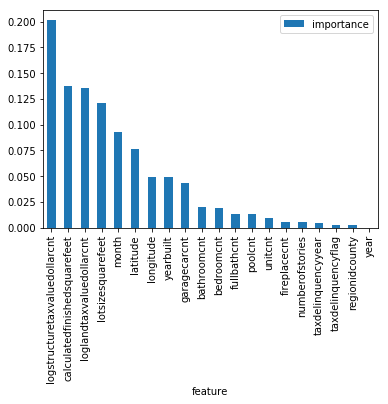

In [38]:
#model 2: more cv

feature_importance(gb_cv.best_estimator_, X_train.columns)

In [46]:
y_gbm_pred = gb_cv.best_estimator_.predict(X_test)

In [48]:
gbm_best_full_prop_predict = gb_cv.best_estimator_.predict(properties_master_new)

In [49]:
print(properties_master_new.shape)
gbm_best_full_prop_predict.shape

(2985217, 73)


(2985217,)

In [50]:
output = pd.DataFrame({'ParcelId': properties_master['parcelid'],
                       '201610': gbm_best_full_prop_predict, 
                       '201611': gbm_best_full_prop_predict, 
                       '201612': gbm_best_full_prop_predict,
                       '201710': gbm_best_full_prop_predict, 
                       '201711': gbm_best_full_prop_predict, 
                       '201712': gbm_best_full_prop_predict})
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

output.to_csv('zillow_pillow_sub4_gbm.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

In [101]:
print(y_gbm_pred.shape)
y_test.shape


(17687,)


(17687,)

In [106]:
import matplotlib.mlab as mlab

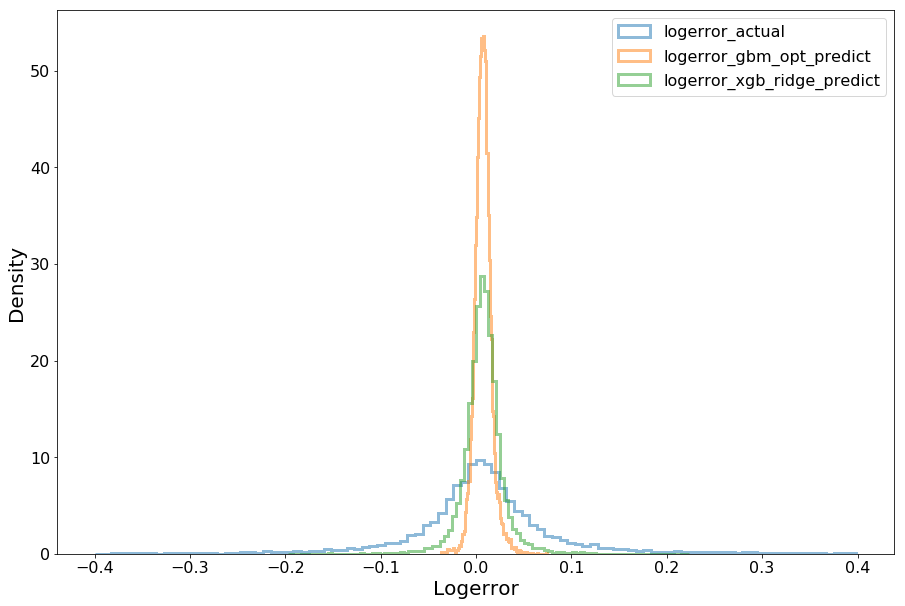

In [130]:
#GBM prediction logloss v test logloss
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(y_test, 100, normed = True, histtype = 'step', lw = 3, facecolor='blue', alpha=0.5, label='logerror_actual')
n, bins, patches = plt.hist(y_gbm_pred, 100, normed = True, histtype = 'step', lw = 3, facecolor='red', alpha=0.5, label='logerror_gbm_opt_predict')
n, bins, patches = plt.hist(y_pred_xgb_ridge, 100, normed = True, histtype = 'step', lw = 3, facecolor='green', alpha=0.5, label='logerror_xgb_ridge_predict')

plt.xlabel('Logerror', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.legend(loc='upper right', fontsize = 16)
plt.savefig('gbm_xgb_logerror_comp.png')

In [108]:
plt.savefig('gbm_xgb_logerror_comp.png')

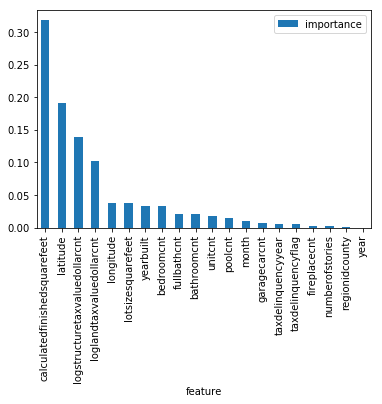

In [15]:
### model 1: limited cv
feature_importance(gb_cv.best_estimator_, X_train.columns)

In [525]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.051670011921244402

In [37]:
#model 11
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.05161686971816349

In [142]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.068399759994235407

In [99]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))

0.068409961572080513

### GBM Models, Hyperparameters, and Results

In [ ]:
###Results

#1) parameters = {'learning_rate': 0.01, 'n_estimators': 20, 'max_depth': 9}
#        cv = 3
#        MAE = .068683817238

#2) parameters = {'n_estimators':[40,60],
#             'learning_rate':[0.07, 0.1],
#             'subsample':[.8,.9],
#             'max_depth':[8,9,10],
#             'max_features':[6,7],
#             'min_samples_split':[300,500,700]
#            }
#  best_params = {'learning_rate': 0.07, 
#                  'max_features': 7, 
#                  'min_samples_split': 500, 
#                  'subsample': 0.8, 
#                  'max_depth': 8, 
#                  'n_estimators': 40}
#         cv = 5
#         MAE = .068389338654760323

#3) model with categorical variables as dummies (including numbath, numbed)

#  parameters = {'n_estimators':[40,50],
#              'learning_rate':[0.06, 0.07],
#              'subsample':[.8,.85],
#              'max_depth':[7,8],
#              'max_features':[7,8],
#              'min_samples_split':[400,500,600]
#             }
#  best_params = {'learning_rate': 0.06, 
#                  'max_features': 8, 
#                  'min_samples_split': 600, 
#                  'subsample': 0.85, 
#                  'max_depth': 7, 
#                  'n_estimators': 40}
#         cv = 5
#         MAE = 0.068436882188459225

#4) model with categorical variables as dummies (including numbath, numbed)

#  parameters = {'n_estimators':[40],
#              'learning_rate':[0.06],
#              'subsample':[.85],
#              'max_depth':[7],
#              'max_features':[12,13,14,15],
#              'min_samples_split':[600]
#             }
#  best_params = {'learning_rate': 0.06, 
#                  'max_features': 14, 
#                  'min_samples_split': 600, 
#                  'subsample': 0.85, 
#                  'max_depth': 7, 
#                  'n_estimators': 40}
#         cv = 5
#         MAE = 0.068409961572080513

#5) model with categorical variables as dummies 
#    (numbath, numbed, totalbath, yearbuilt are numeric continuous)

#  parameters = {'n_estimators':[40],
#              'learning_rate':[0.06],
#              'subsample':[.85],
#              'max_depth':[7],
#              'max_features':[8,9,10],
#              'min_samples_split':[600]
#             }
#  best_params = {'learning_rate': 0.06, 
#              'max_features': 9, 
#              'min_samples_split': 600, 
#              'subsample': 0.85, 
#              'max_depth': 7, 
#              'n_estimators': 40}
#         cv = 5
#         MAE = 0.068399759994235407

#6) model with categorical variables as dummies 
#    (numbath, numbed, totalbath, yearbuilt are numeric continuous)

#GridSearchCV(cv=5, error_score='raise',
#       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
#             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=1,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=100, presort='auto', random_state=42,
#             subsample=1.0, verbose=0, warm_start=False),
#       fit_params=None, iid=True, n_jobs=1,
#       param_grid={'learning_rate': [0.06], 'max_features': [8, 9, 10], 'min_samples_split': [600], 'subsample': [0.85], 'n_estimators': [40], 'max_depth': [7, 8, 9]},
#       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
#       scoring='neg_mean_absolute_error', verbose=0)

#  best_params = {'learning_rate': 0.06, 
#              'max_features': 10, 
#              'min_samples_split': 600, 
#              'subsample': 0.85, 
#              'max_depth': 9, 
#              'n_estimators': 40}
#         cv = 5
#         MAE = 0.051709528473036941

#7) GridSearchCV(cv=5, error_score='raise',
#       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
#             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=1,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=100, presort='auto', random_state=42,
#             subsample=1.0, verbose=0, warm_start=False),
#       fit_params=None, iid=True, n_jobs=1,
#       param_grid={'learning_rate': [0.06], 'max_features': [10, 11, 12], 'min_samples_split': [600], 'subsample': [0.85], 'n_estimators': [40], 'max_depth': [9, 10, 11]},
#       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
#       scoring='neg_mean_absolute_error', verbose=0)

#  best_params = {'learning_rate': 0.06, 
#              'max_features': 11, 
#              'min_samples_split': 600, 
#              'subsample': 0.85, 
#              'max_depth': 11, 
#              'n_estimators': 40}
#         cv = 5
#         MAE = 0.051662932594411022

#8) GridSearchCV(cv=5, error_score='raise',
#       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
#             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=1,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=100, presort='auto', random_state=42,
#             subsample=1.0, verbose=0, warm_start=False),
#       fit_params=None, iid=True, n_jobs=1,
#       param_grid={'learning_rate': [0.06], 'max_features': [11], 'min_samples_split': [600], 'subsample': [0.85], 'n_estimators': [40], 'max_depth': [11, 12, 13]},
#       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
#       scoring='neg_mean_absolute_error', verbose=0)

#  best_params = {'learning_rate': 0.06, 
#              'max_features': 11, 
#              'min_samples_split': 600, 
#              'subsample': 0.85, 
#              'max_depth': 11, 
#              'n_estimators': 40}
#         cv = 5
#         MAE = 0.051662932594411022

### XGBoost

In [ ]:
#Reminder: X_train, X_test, y_train, y_test = train_test_split(train_xnew, train_y, test_size=0.2, random_state=42)

### Cross validation

In [75]:
#checking lasso
cv_params = {'max_depth': [7,8]}
ind_params = {'learning_rate': 0.06, 'n_estimators': 1000, 'seed':42, 'min_child_weight': 1,
              'subsample': 0.85, 'colsample_bytree': 0.7,'reg_alpha':1, 'reg_lambda':0,
              'objective': 'reg:linear'}
optimized_XGBM = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                              cv_params,
                              scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1) 

In [80]:
#checking ridge
cv_params = {'max_depth': [7,8]}
ind_params_ridge = {'learning_rate': 0.06, 'n_estimators': 1000, 'seed':42, 'min_child_weight': 1,
              'subsample': 0.85, 'colsample_bytree': 0.7,'reg_alpha':0, 'reg_lambda':1,
              'objective': 'reg:linear'}

ridge_optimized = GridSearchCV(xgb.XGBRegressor(**ind_params_ridge), 
                              cv_params,
                              scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1) 

In [70]:
X_train.shape

(70744, 73)

In [73]:
y_train.shape

(70744,)

In [74]:
optimized_XGBM.get_params().keys()

dict_keys(['estimator__subsample', 'estimator__max_delta_step', 'pre_dispatch', 'estimator__base_score', 'error_score', 'scoring', 'estimator__scale_pos_weight', 'iid', 'param_grid', 'estimator__colsample_bytree', 'refit', 'estimator__silent', 'fit_params', 'estimator__min_child_weight', 'n_jobs', 'estimator__missing', 'estimator__n_estimators', 'estimator__nthread', 'return_train_score', 'estimator__seed', 'estimator', 'estimator__reg_lambda', 'estimator__gamma', 'verbose', 'estimator__max_depth', 'estimator__learning_rate', 'cv', 'estimator__colsample_bylevel', 'estimator__reg_alpha', 'estimator__objective'])

In [81]:
ridge_optimized.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.06, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.85),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [7, 8]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [82]:
ridge_optimized.grid_scores_

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.05410, std: 0.00061, params: {'max_depth': 7},
 mean: -0.05453, std: 0.00059, params: {'max_depth': 8}]

In [77]:
optimized_XGBM.grid_scores_

/Users/Patrick/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.05428, std: 0.00056, params: {'max_depth': 7},
 mean: -0.05484, std: 0.00052, params: {'max_depth': 8}]

In [86]:
#early stopping cv

xgdmat = xgb.DMatrix(X_train, y_train) # Create our DMatrix to make XGBoost more efficient

In [389]:
best_params_lasso = {'learning_rate': 0.06, 'seed':42, 'subsample': 0.85, 'colsample_bytree': 0.7, 
             'objective': 'reg:linear', 'max_depth':7, 'min_child_weight':1,
               'reg_alpha':1, 'reg_lambda':0} 

cv_xgb = xgb.cv(params = best_params_lasso, dtrain = xgdmat, num_boost_round = 1000, nfold = 5,
                metrics = ['rmse'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 150) # Look for early stopping that minimizes error

In [ ]:
best_params_ridge = {'learning_rate': 0.06, 'seed':42, 'subsample': 0.85, 'colsample_bytree': 0.7, 
             'objective': 'reg:linear', 'max_depth':7, 'min_child_weight':1,
               'reg_alpha':0, 'reg_lambda':1} 

cv_xgb = xgb.cv(params = best_params_lasso, dtrain = xgdmat, num_boost_round = 1000, nfold = 5,
                metrics = ['rmse'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 150) # Look for early stopping that minimizes error

In [95]:
best_params_elasticnet = {'learning_rate': 0.06, 'seed':42, 'subsample': 0.85, 'colsample_bytree': 0.7, 
             'objective': 'reg:linear', 'max_depth':7, 'min_child_weight':1,
               'reg_alpha':.5, 'reg_lambda':.5} 

In [390]:
cv_xgb.tail(5)

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
152,0.082266,0.001316,0.076549,0.000356
153,0.082268,0.001321,0.076514,0.000361
154,0.082265,0.001319,0.076491,0.000354
155,0.082264,0.001319,0.076462,0.000363
156,0.082262,0.001316,0.076435,0.000372


In [87]:
final_gb_lasso = xgb.train(best_params_lasso, xgdmat, num_boost_round = 1000)

In [92]:
final_gb_ridge = xgb.train(best_params_ridge, xgdmat, num_boost_round = 1000)

In [96]:
final_gb_elasticnet = xgb.train(best_params_elasticnet, xgdmat, num_boost_round = 1000)

In [392]:
xgdmat

In [88]:
testdmat = xgb.DMatrix(X_test)

In [90]:
y_pred_xgb_lasso = final_gb_lasso.predict(testdmat)

In [93]:
y_pred_xgb_ridge = final_gb_ridge.predict(testdmat)

In [97]:
y_pred_xgb_elasticnet = final_gb_elasticnet.predict(testdmat)

In [91]:
mean_absolute_error(y_test, y_pred_xgb_lasso)

0.052996081863086165

In [94]:
mean_absolute_error(y_test, y_pred_xgb_ridge)

0.052879917489048751

In [98]:
mean_absolute_error(y_test, y_pred_xgb_elasticnet)

0.053169822203691756

In [395]:
mean_absolute_error(y_test, y_pred)

0.052879917489048751

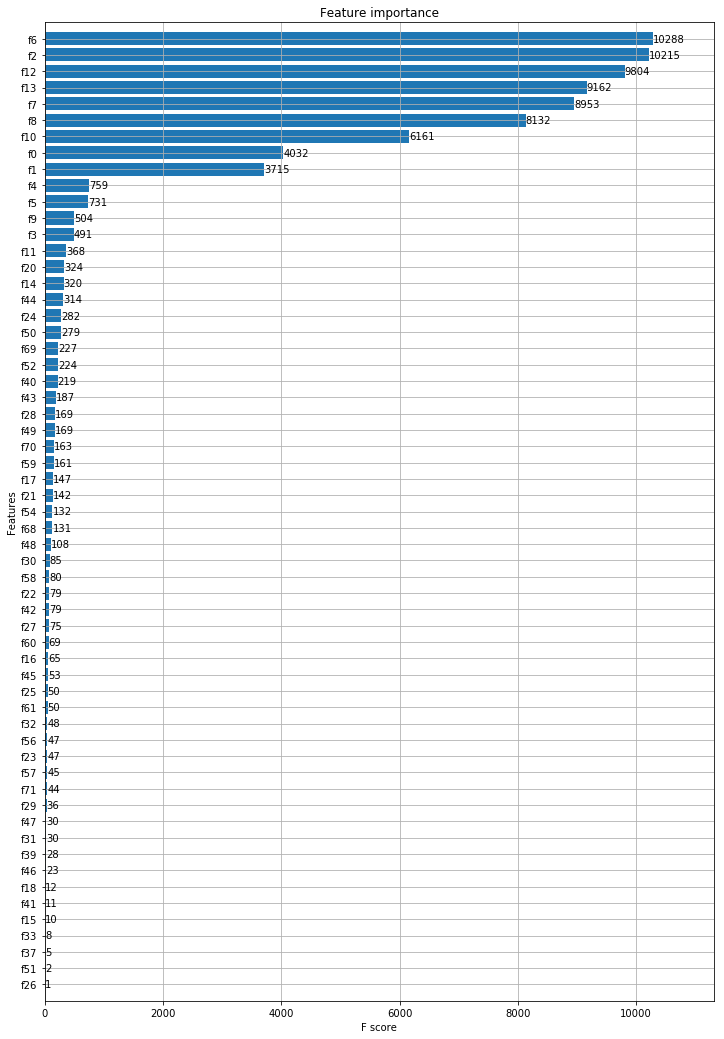

In [111]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(final_gb_ridge, height=0.8, ax=ax)
plt.show()

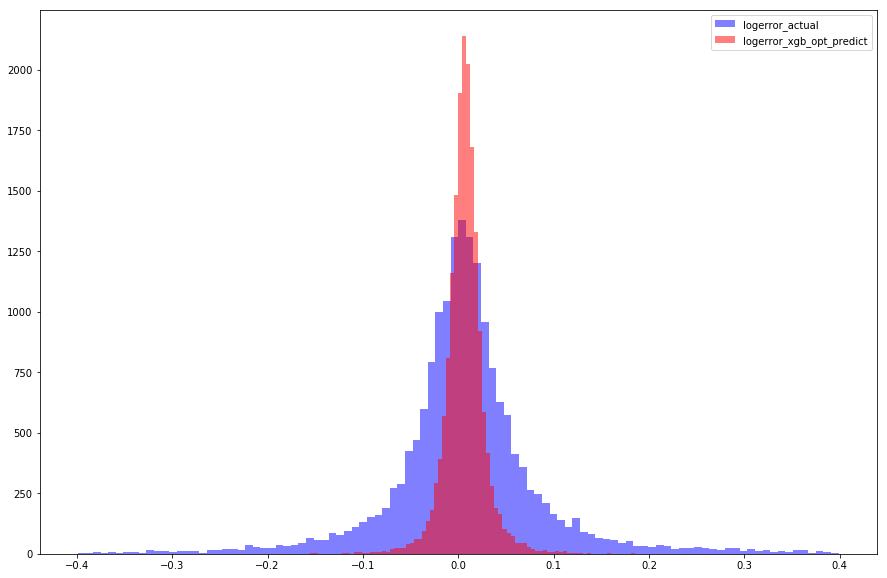

In [398]:
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(y_test, 100, facecolor='blue', alpha=0.5, label='logerror_actual')
n, bins, patches = plt.hist(y_pred, 100, facecolor='red', alpha=0.5, label='logerror_xgb_opt_predict')
plt.legend(loc='upper right')
plt.show()

In [399]:
y_pred

array([ 0.00273201,  0.00234199,  0.00896353, ..., -0.00963867,
       -0.0146389 ,  0.01718989], dtype=float32)

In [400]:
y_test

array([-0.0141,  0.0188, -0.0305, ..., -0.1672,  0.0667,  0.062 ])

In [401]:
prop_predict_dmat = xgb.DMatrix(properties_master_new)

In [402]:
xgb_best_full_prop_predict = final_gb.predict(prop_predict_dmat)

In [406]:
print(properties_master_new.shape)
print(xgb_best_full_prop_predict.shape)

(2985217, 73)
(2985217,)


In [408]:
output = pd.DataFrame({'ParcelId': properties_master['parcelid'],
                       '201610': xgb_best_full_prop_predict, 
                       '201611': xgb_best_full_prop_predict, 
                       '201612': xgb_best_full_prop_predict,
                       '201710': xgb_best_full_prop_predict, 
                       '201711': xgb_best_full_prop_predict, 
                       '201712': xgb_best_full_prop_predict})
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

output.to_csv('zillow_pillow_sub2.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

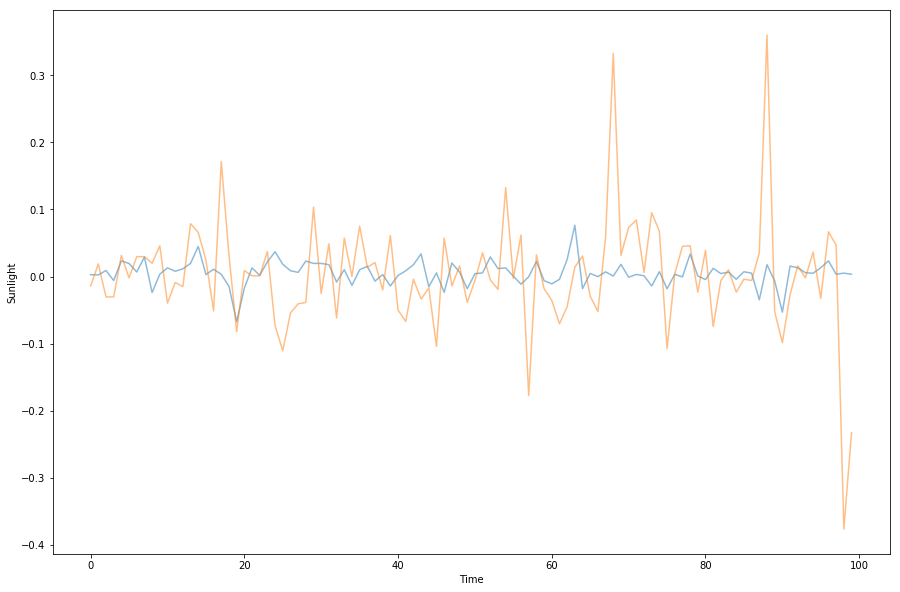

In [409]:
plt.figure(figsize=(15,10))

plt.plot(y_pred[:100], alpha = .5)
plt.plot(y_test[:100], alpha = .5)

plt.ylabel('Sunlight')
plt.xlabel('Time')
plt.show()

### 2) Set parameters

In [148]:
xgb_params = {
    'learning_rate':.06,
    'eta': 0.01,
    'max_depth': 7,
    'subsample': 0.85,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 0,
    'seed': 42
}

num_round = 5000

early_stopping_rounds=50

nfold = 10

### 3) Set train matrix and model

In [146]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

### 4) Set number of boosting rounds

In [159]:
num_boost_rounds = 5000

### 5) Train model

In [171]:
progress = dict()
watchlist  = [(dtrain,'train-rmse'), (dtest, 'eval-rmse')]

In [174]:
model = xgb.train(dict(xgb_params), dtrain, num_boost_round=num_boost_rounds)
# early_stopping_rounds = 50, watchlist = watchlist, evals_result=progress

# silence = 0 to watch the rows.

In [175]:
modelfit(model)

NameError: name 'modelfit' is not defined

### 6) Predict test values

In [176]:
xgb_predict = model.predict(dtest)

In [177]:
mean_absolute_error(y_test, xgb_predict)

0.078727519028184811

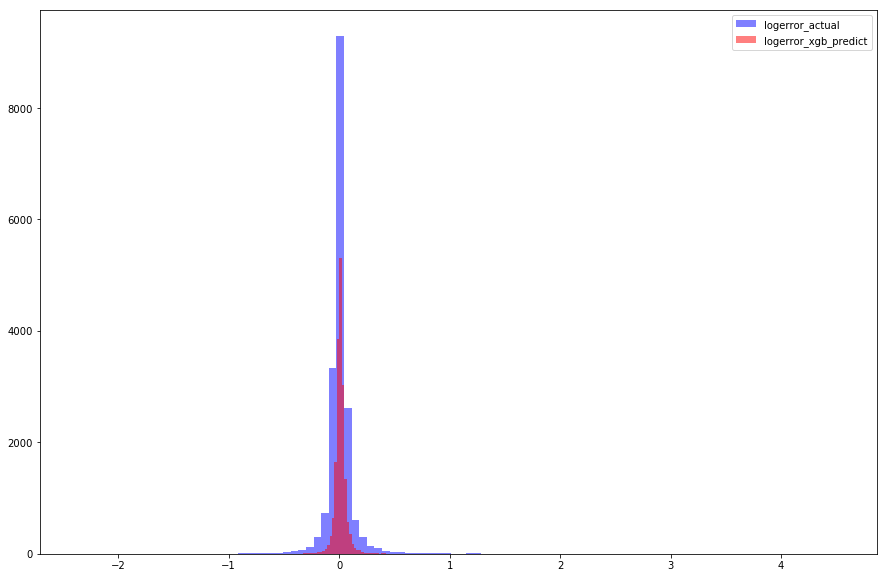

In [184]:
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(y_test, 100, facecolor='blue', alpha=0.5, label='logerror_actual')
n, bins, patches = plt.hist(xgb_predict, 100, facecolor='red', alpha=0.5, label='logerror_xgb_predict')
plt.legend(loc='upper right')
plt.show()

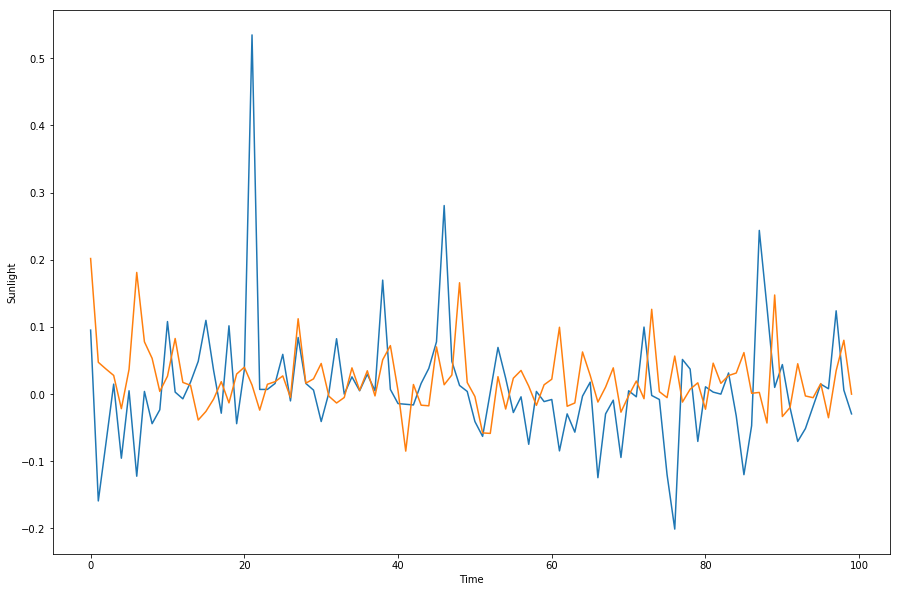

In [195]:
plt.figure(figsize=(15,10))

plt.plot(y_test[1000:1100])
plt.plot(xgb_predict[1000:1100])



plt.ylabel('Logerror')
plt.xlabel('Observations')
plt.show()

In [ ]:
#1) model with categorical variables as dummies 
#    (numbath, numbed, totalbath, yearbuilt are numeric continuous)


#xgb_params = {
#    'learning_rate':.06,
#    'eta': 0.01,
#    'max_depth': 7,
#    'subsample': 0.85,
#    'colsample_bytree': 0.7,
#    'objective': 'reg:linear',
#    'silent': 0,
#    'seed': 42
#}

#num_round = 5000

#early_stopping_rounds=none

#         MAE = 0.078727519028184811

#2) Model with cv for max_depth and min_child_weight
#GridSearchCV(cv=5, error_score='raise',
#       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
#       gamma=0, learning_rate=0.06, max_delta_step=0, max_depth=3,
#       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
#       objective='reg:linear', reg_alpha=0, reg_lambda=1,
#       scale_pos_weight=1, seed=42, silent=True, subsample=0.85),
#       fit_params=None, iid=True, n_jobs=-1,
#       param_grid={'max_depth': [7, 8, 9], 'min_child_weight': [1, 3, 5]},
#       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
#       scoring='neg_mean_absolute_error', verbose=0)

#[mean: -0.05410, std: 0.00061, params: {'max_depth': 7, 'min_child_weight': 1},
# mean: -0.05417, std: 0.00055, params: {'max_depth': 7, 'min_child_weight': 3},
# mean: -0.05419, std: 0.00056, params: {'max_depth': 7, 'min_child_weight': 5},
# mean: -0.05453, std: 0.00059, params: {'max_depth': 8, 'min_child_weight': 1},
# mean: -0.05455, std: 0.00060, params: {'max_depth': 8, 'min_child_weight': 3},
# mean: -0.05459, std: 0.00057, params: {'max_depth': 8, 'min_child_weight': 5},
# mean: -0.05483, std: 0.00056, params: {'max_depth': 9, 'min_child_weight': 1},
# mean: -0.05501, std: 0.00062, params: {'max_depth': 9, 'min_child_weight': 3},
# mean: -0.05501, std: 0.00057, params: {'max_depth': 9, 'min_child_weight': 5}]

#best params: max_depth = 7, min_child_weight = 1

#         MAE = 0.052879917489048751

### 7) Set up writing predictions to csv

In [77]:
output = pd.DataFrame({'ParcelId': properties_master['parcelid'],
                      '201610': xgb_predict, '201611': xgb_predict, '201612': xgb_predict,
                      '201710': xgb_predict, '201711': xgb_predict, '201712': xgb_predict})
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

output.to_csv('zillow_pillow_sub1.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

### 4) Visualize Feature Importance

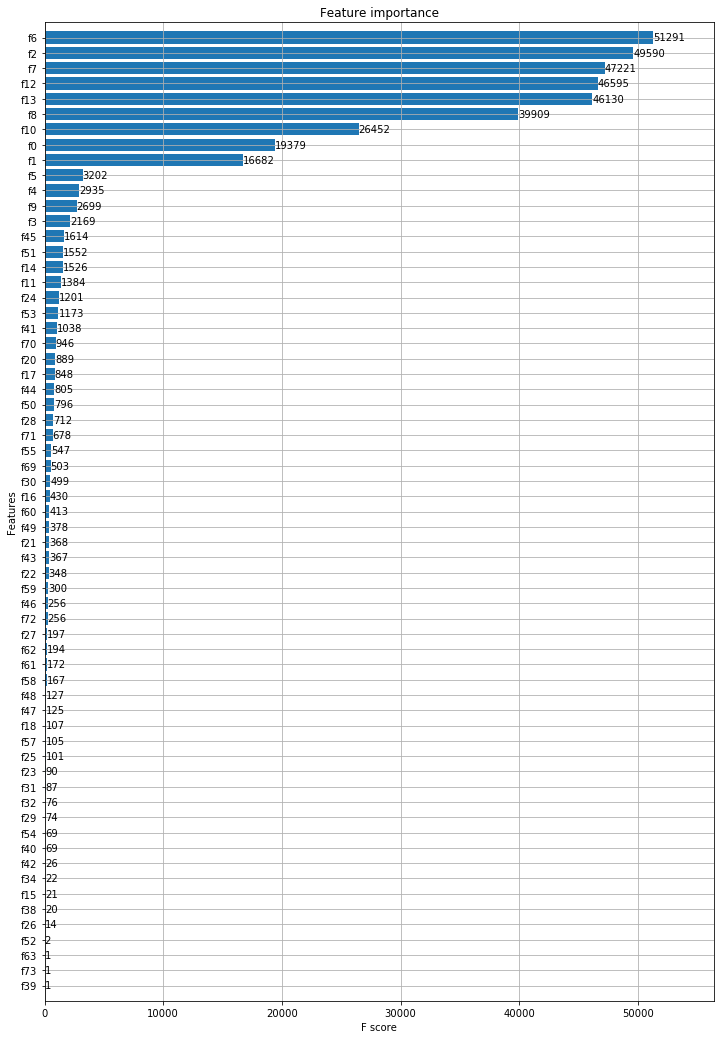

In [197]:
#imputed values
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

### kNN

In [ ]:
###Results

#1)
#knn first try
#n_neighbors = 10
#knn = KNeighborsRegressor(n_neighbors, weights = 'uniform')
#knn_predict = knn.fit(X_train, y_train).predict(X_test)
#knn_r_square = knn.score(X_train, y_train)
#print(knn_r_square)

#   R2 = .1144286
#   MAE = 0.056678531689941768

#2) 
# same as #1 except distance instead of uniform

#   R2 = .9984
#   MAE = 0.058111093870756456

#3)
#with normalized variables

#   MAE = 0.056732987504947131

In [451]:
#knn first try
n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors, weights = 'uniform')
knn_predict = knn.fit(X_train, y_train).predict(X_test)
knn_r_square = knn.score(X_train, y_train)
print(knn_r_square)


0.114428617212


In [452]:
#knn 1: MAE
mean_absolute_error(y_test, knn_predict)

0.056678531689941768

In [453]:
#knn first try UNIFORM
n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors, weights = 'distance')
knn_predict = knn.fit(X_train, y_train).predict(X_test)
knn_r_square = knn.score(X_train, y_train)
print(knn_r_square)

0.998485094659


In [454]:
#knn 2: uniform MAE
mean_absolute_error(y_test, knn_predict)

0.058111093870756456

In [113]:
#CV
K_range = list(range(1,50,2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in K_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights = 'uniform')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring = 'neg_mean_absolute_error')
    cv_scores.append(scores.mean())

In [114]:
optimal_k = K_range[cv_scores.index(max(cv_scores))]
optimal_k

49

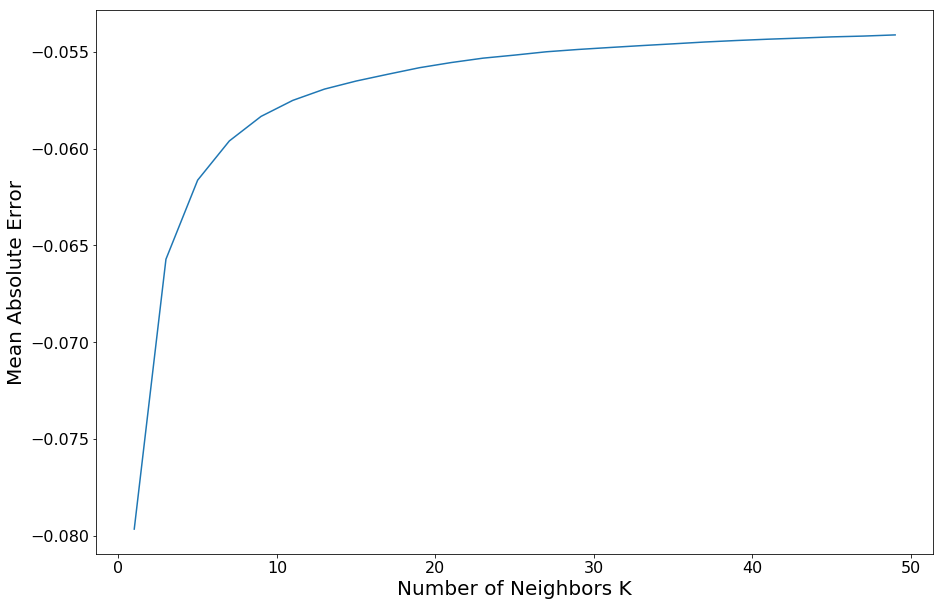

In [124]:
plt.figure(figsize=(15,10))
plt.plot(K_range, cv_scores)
plt.xlabel('Number of Neighbors K', fontsize = 20)
plt.ylabel('Mean Absolute Error', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.savefig('knn_cross_valid.png')

In [441]:
print(knn_predict)
print(y_test)

[ 0.02926925  0.02973155  0.03984084 ..., -0.05864692 -0.02136793
 -0.02188388]
[-0.0141  0.0188 -0.0305 ..., -0.1672  0.0667  0.062 ]


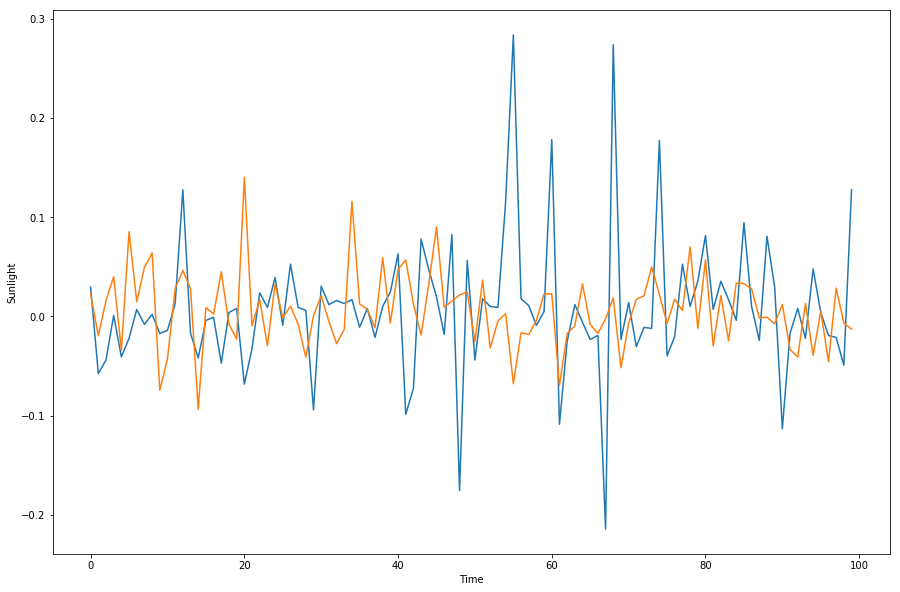

In [440]:
plt.figure(figsize=(15,10))

plt.plot(y_test[6000:6100])
plt.plot(knn_predict[6000:6100])



plt.ylabel('Sunlight')
plt.xlabel('Time')
plt.show()

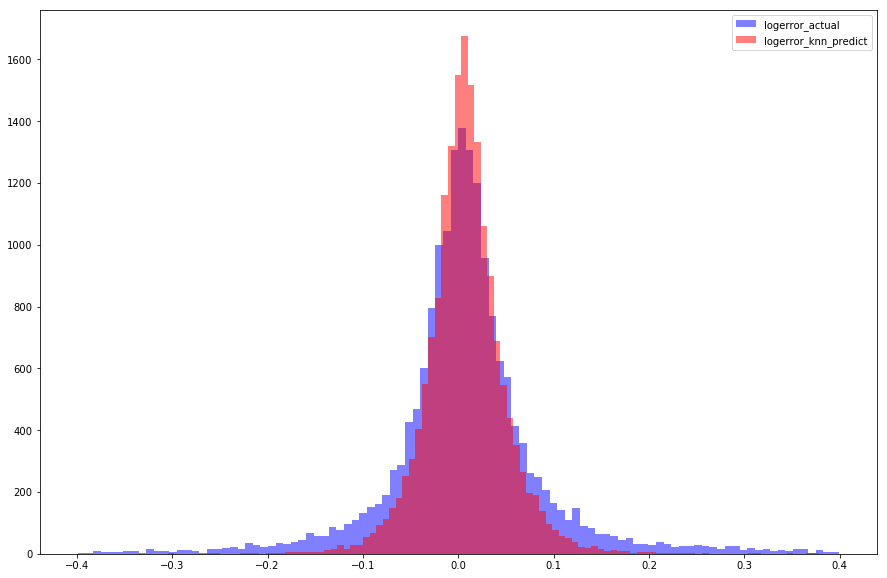

In [439]:
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(y_test, 100, facecolor='blue', alpha=0.5, label='logerror_actual')
n, bins, patches = plt.hist(knn_predict, 100, facecolor='red', alpha=0.5, label='logerror_knn_predict')
plt.legend(loc='upper right')
plt.show()

In [469]:
train_x.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'heatingorsystemtypeid', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'propertylandusetypeid',
       'regionidcounty', 'unitcnt', 'yearbuilt', 'numberofstories',
       'taxdelinquencyflag', 'logstructuretaxvaluedollarcnt',
       'loglandtaxvaluedollarcnt'],
      dtype='object')

### Normalize numeric variables

In [477]:
train_x_norm = train_x

In [483]:
train_x_norm = normalize(train_x_norm[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'lotsizesquarefeet', 'poolcnt', 
       'yearbuilt','logstructuretaxvaluedollarcnt',
       'loglandtaxvaluedollarcnt']])

In [502]:
properties_master_ready_norm = properties_master_ready

In [503]:
properties_master_ready_norm = normalize(properties_master_ready_norm[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'lotsizesquarefeet', 'poolcnt', 
       'yearbuilt','logstructuretaxvaluedollarcnt',
       'loglandtaxvaluedollarcnt']])

### Scale numeric variables

In [504]:
train_x_scale = train_x

In [507]:
train_x_scale = scale(train_x_scale[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'lotsizesquarefeet', 'poolcnt', 
       'yearbuilt','logstructuretaxvaluedollarcnt',
       'loglandtaxvaluedollarcnt']])

In [508]:
properties_master_ready_scale = properties_master_ready

In [509]:
properties_master_ready_scale = normalize(properties_master_ready_scale[['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'lotsizesquarefeet', 'poolcnt', 
       'yearbuilt','logstructuretaxvaluedollarcnt',
       'loglandtaxvaluedollarcnt']])

In [510]:
print(train_x.shape)
print(train_x_norm.shape)
print(train_x_scale.shape)

(88431, 21)
(88431, 11)
(88431, 11)


In [512]:
train_x_norm2 = np.concatenate((train_x_norm,
                                airconditioningtypeid_array_train_x,
                                propertylandusetypeid_array_train_x,
                                heatingorsystemtypeid_array_train_x,
                                regionidcounty_array_train_x,
                                buildingqualitytypeid_array_train_x,
                                unitcnt_array_train_x,
                                numberofstories_array_train_x), axis = 1)

In [513]:
properties_master_ready_norm = np.concatenate((properties_master_ready_norm,
                                airconditioningtypeid_array_pmr,
                                propertylandusetypeid_array_pmr,
                                heatingorsystemtypeid_array_pmr,
                                regionidcounty_array_pmr,
                                buildingqualitytypeid_array_pmr,
                                unitcnt_array_pmr,
                                numberofstories_array_pmr), axis = 1)

In [514]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(train_x_norm2, train_y, test_size=0.2, random_state=42)

In [515]:
train_x_scale2 = np.concatenate((train_x_scale,
                                airconditioningtypeid_array_train_x,
                                propertylandusetypeid_array_train_x,
                                heatingorsystemtypeid_array_train_x,
                                regionidcounty_array_train_x,
                                buildingqualitytypeid_array_train_x,
                                unitcnt_array_train_x,
                                numberofstories_array_train_x), axis = 1)

In [516]:
properties_master_ready_scale = np.concatenate((properties_master_ready_scale,
                                airconditioningtypeid_array_pmr,
                                propertylandusetypeid_array_pmr,
                                heatingorsystemtypeid_array_pmr,
                                regionidcounty_array_pmr,
                                buildingqualitytypeid_array_pmr,
                                unitcnt_array_pmr,
                                numberofstories_array_pmr), axis = 1)

In [517]:
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(train_x_scale2, train_y, test_size=0.2, random_state=42)

In [518]:
#knn model 4 with scaled variables
n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors, weights = 'uniform')
knn_predict = knn.fit(X_train_scale, y_train_scale).predict(X_test_scale)
knn_r_square = knn.score(X_train_scale, y_train_scale)
print(knn_r_square)

0.129782489939


In [ ]:
#knn 4: MAE
mean_absolute_error(y_test_scale, knn_predict)

In [ ]:
1+1

In [ ]:
knn_best_full_prop_predict = knn.fit(X_train_scale, y_train_scale).predict(properties_master_ready_scale)

In [ ]:
output = pd.DataFrame({'ParcelId': properties_master['parcelid'],
                       '201610': knn_best_full_prop_predict, 
                       '201611': knn_best_full_prop_predict, 
                       '201612': knn_best_full_prop_predict,
                       '201710': knn_best_full_prop_predict, 
                       '201711': knn_best_full_prop_predict, 
                       '201712': knn_best_full_prop_predict})
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]

output.to_csv('zillow_pillow_sub4_knn.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

In [497]:
#knn model 3 with normalized variables
n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors, weights = 'uniform')
knn_predict = knn.fit(X_train_norm, y_train_norm).predict(X_test_norm)
knn_r_square = knn.score(X_train_norm, y_train_norm)
print(knn_r_square)

0.113976869759


In [498]:
#knn 3: MAE
mean_absolute_error(y_test_norm, knn_predict)

0.056732987504947131

In [ ]:
#CV
K_range = list(range(1,50,2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in K_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights = 'uniform')
    scores = cross_val_score(knn, X_train_norm, y_train_norm, cv=10, scoring = 'neg_mean_absolute_error')
    cv_scores.append(scores.mean())

In [ ]:
#visualize MAE by K choice

plt.figure(figsize=(15,10))
plt.plot(K_range, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Absolute Error')
plt.show()

### Model Stacking

In [27]:
###Model Stacking
mlr = pd.read_csv('zillow_mlr2_submission_JM.csv')
mlm = pd.read_csv('zillow_mlm_submission.csv')
rf = pd.read_csv('rf_submission.csv')
gbm = pd.read_csv('zillow_pillow_sub4_gbm.csv')
xgb = pd.read_csv('zillow_pillow_sub2.csv')

In [29]:
mlr = mlr.rename(columns={"ParcelId": "parcelid", "201610": "mlr201610", "201611": "mlr201611", "201612": "mlr201612",
                   "201710": "mlr201710", "201711": "mlr201711", "201712": "mlr201712"})
mlm = mlm.rename(columns={"ParcelId": "parcelid", "201610": "mlm201610", "201611": "mlm201611", "201612": "mlm201612",
                   "201710": "mlm201710", "201711": "mlm201711", "201712": "mlm201712"})
rf = rf.rename(columns={"201610": "rf201610", "201611": "rf201611", "201612": "rf201612",
                   "201710": "rf201710", "201711": "rf201711", "201712": "rf201712"})
gbm = gbm.rename(columns={"ParcelId": "parcelid", "201610": "gbm201610", "201611": "gbm201611", "201612": "gbm201612",
                   "201710": "gbm201710", "201711": "gbm201711", "201712": "gbm201712"})
xgb = xgb.rename(columns={"ParcelId": "parcelid", "201610": "xgb201610", "201611": "xgb201611", "201612": "xgb201612",
                   "201710": "xgb201710", "201711": "xgb201711", "201712": "xgb201712"})

In [31]:
stacked = mlr.merge(mlm, how = 'inner', on = 'parcelid')
stacked = stacked.merge(rf, how = 'inner', on = 'parcelid')
stacked = stacked.merge(gbm, how = 'inner', on = 'parcelid')
stacked = stacked.merge(xgb, how = 'inner', on = 'parcelid')

In [50]:
stacked_small = stacked[['mlr201610', 'mlm201610', 'rf201610', 'gbm201610', 'xgb201610']]

In [51]:
stacked_small.corr()

,mlr201610,mlm201610,rf201610,gbm201610,xgb201610
mlr201610,1.000000,0.414716,0.069412,0.115705,0.048403
mlm201610,0.414716,1.000000,0.148802,0.241655,0.125821
rf201610,0.069412,0.148802,1.000000,0.502432,0.440280
gbm201610,0.115705,0.241655,0.502432,1.000000,0.613095
xgb201610,0.048403,0.125821,0.440280,0.613095,1.000000


In [52]:
stacked['201610'] = .2*stacked['mlr201610']+.2*stacked['mlm201610']+.2*stacked['rf201610']+.2*stacked['gbm201610']+.2*stacked['xgb201610']

In [54]:
stacked['201611'] = .2*stacked['mlr201611']+.2*stacked['mlm201611']+.2*stacked['rf201611']+.2*stacked['gbm201611']+.2*stacked['xgb201611']
stacked['201612'] = .2*stacked['mlr201612']+.2*stacked['mlm201612']+.2*stacked['rf201612']+.2*stacked['gbm201612']+.2*stacked['xgb201612']
stacked['201710'] = .2*stacked['mlr201710']+.2*stacked['mlm201710']+.2*stacked['rf201710']+.2*stacked['gbm201710']+.2*stacked['xgb201710']
stacked['201711'] = .2*stacked['mlr201711']+.2*stacked['mlm201711']+.2*stacked['rf201711']+.2*stacked['gbm201711']+.2*stacked['xgb201711']
stacked['201712'] = .2*stacked['mlr201712']+.2*stacked['mlm201712']+.2*stacked['rf201712']+.2*stacked['gbm201712']+.2*stacked['xgb201712']


In [59]:
stacked_avg = stacked[['parcelid','201610','201611','201612','201710','201711','201712']]
stacked_avg = stacked_avg.rename(columns={"parcelid": "ParcelId"})

In [62]:
stacked_avg.to_csv('pillow_stacked_avg.csv', index=False)